   FOOTBALL MATCH PREDICTOR (Advanced Pipeline)   
Loaded 489 matches from match_data.csv
Parsing compound stats (e.g., '5 of 16')...
Calculating Weighted xG for missing values...
Imputing remaining stats with Team Medians...
Generating Rolling Averages (Window=5)...
Creating Differential Features...
Final Feature Count: 19
Train Size: 440 | Test Size: 49
   FINAL ACCURACY: 61.22%   

New Confusion Matrix (Rows=Actual, Cols=Pred):
[[13  4  0]
 [ 2  5  1]
 [ 5  7 12]]

--- High Confidence Bets ---
Threshold > 0.40: 20 matches | Accuracy: 65.00%
Threshold > 0.45: 8 matches | Accuracy: 75.00%

--- Top 10 Features ---
                         Feature  Importance
14          diff_team_possession    0.140108
13                  diff_team_xg    0.088049
1           home_rolling_team_xg    0.067818
12              diff_team_points    0.067272
16                    diff_fouls    0.055587
15                  diff_corners    0.047507
9           away_rolling_corners    0.047043
2   home_rolling_t

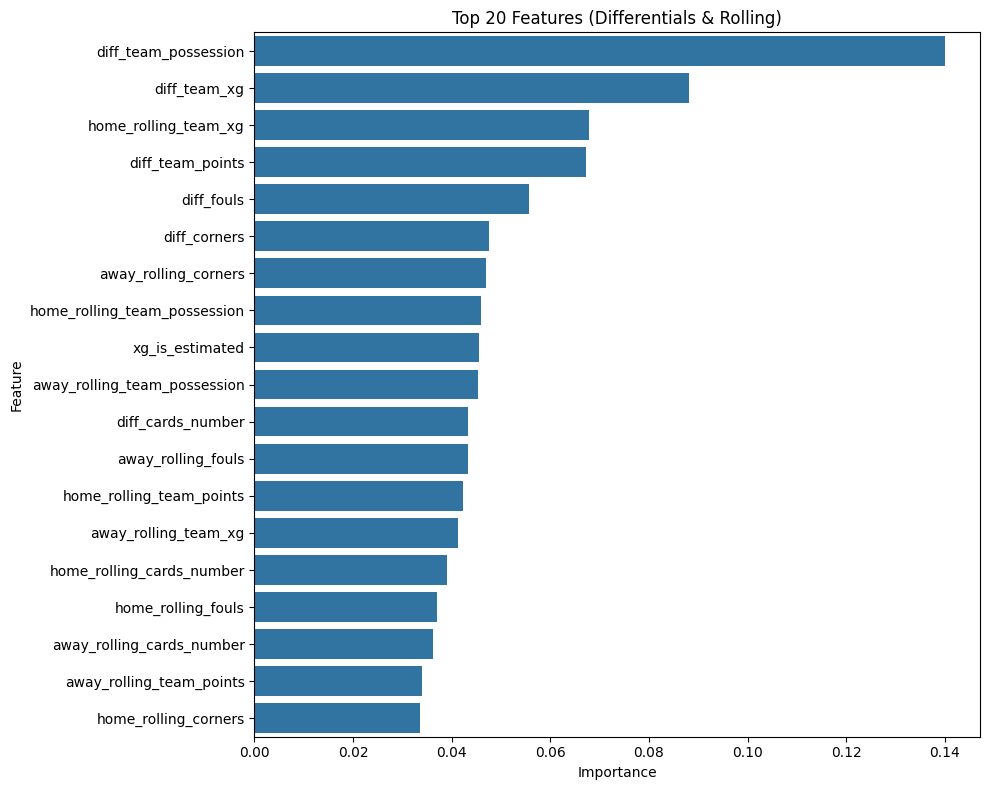


--- Sample Predictions ---
Atalanta vs Cagliari: Pred Home Win (0.48) | Actual Home Win
Liverpool vs Brighton & Hove Albion: Pred Home Win (0.34) | Actual Home Win
Sporting CP vs AVS Futebol: Pred Home Win (0.45) | Actual Home Win
Arsenal vs Wolverhampton Wanderers: Pred Home Win (0.50) | Actual Home Win
Metz vs Paris Saint-Germain: Pred Away Win (0.41) | Actual Away Win


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import confusion_matrix


# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("==================================================")
print("   FOOTBALL MATCH PREDICTOR (Advanced Pipeline)   ")
print("==================================================")

# ==========================================
# 1. LOAD & BASIC PARSING
# ==========================================
csv_file = "match_data.csv"
try:
    df = pd.read_csv(csv_file)
    print(f"Loaded {len(df)} matches from {csv_file}")
except FileNotFoundError:
    print("Error: match_data.csv not found.")
    exit()

# --- A. Date Extraction (Crucial for sorting) ---
def extract_date_from_url(url):
    try:
        # Regex for "December-7-2025" or similar patterns in FBref URLs
        match = re.search(r'([A-Za-z]+-\d{1,2}-\d{4})', str(url))
        if match:
            return pd.to_datetime(match.group(1), format='%B-%d-%Y', errors='coerce')
    except:
        pass
    return pd.NaT

df['date'] = df['match_url'].apply(extract_date_from_url)
# Sort chronologically to ensure rolling averages look at the PAST, not future
df = df.sort_values(by='date').reset_index(drop=True)

# --- B. Parse "Compound" Strings (e.g. "5 of 16") ---
# FBref often returns "Completed of Attempted". We need both numbers.
def parse_compound_stat(series):
    """Parses '5 of 16' into (5, 16). Returns two series."""
    # Ensure string
    s = series.astype(str)
    
    # Extract first number (Completed/OnTarget)
    v1 = pd.to_numeric(s.str.split('of').str[0], errors='coerce')
    
    # Extract second number (Total) - usually comes after 'of' and before '—' or end
    v2 = pd.to_numeric(s.str.split('of').str[1].str.split('—').str[0], errors='coerce')
    
    return v1, v2

# List of columns that might be in "X of Y" format
compound_cols = ['passing', 'shots', 'saves'] # You can add 'tackles' if scraped that way

print("Parsing compound stats (e.g., '5 of 16')...")
for col_root in compound_cols:
    for side in ['home', 'away']:
        # The column names coming from your scraper (e.g., home_pass_accuracy, home_shot_accuracy)
        # Adjust these names based on exactly what is in your CSV
        
        # Mapping scraper names to our clean names:
        # If your scraper called it "home_shot_accuracy" but it contains "5 of 16"
        target_col = f"{side}_{col_root}_accuracy" 
        
        if target_col in df.columns:
            # Check if it looks like a string with "of"
            if df[target_col].dtype == 'object' and df[target_col].str.contains('of').any():
                v1, v2 = parse_compound_stat(df[target_col])
                df[f"{side}_{col_root}_completed"] = v1 # e.g. home_shots_completed (On Target)
                df[f"{side}_{col_root}_total"] = v2     # e.g. home_shots_total
            else:
                # Already numeric? treat as total
                df[f"{side}_{col_root}_total"] = pd.to_numeric(df[target_col], errors='coerce')

# Clean Possession (Remove %)
for side in ['home', 'away']:
    col = f"{side}_team_possession" # or home_possession based on your scraper
    if col not in df.columns: col = f"{side}_possession" # fallback
    
    if col in df.columns:
        df[col] = pd.to_numeric(df[col].astype(str).str.rstrip('%'), errors='coerce').fillna(50) / 100.0

# ==========================================
# 2. ADVANCED IMPUTATION (The "Weighted xG" Logic)
# ==========================================
print("Calculating Weighted xG for missing values...")

for side in ['home', 'away']:
    xg_col = f"{side}_team_xg"
    if xg_col not in df.columns: xg_col = f"{side}_xg"
    
    sot_col = f"{side}_shots_completed" # On Target
    total_col = f"{side}_shots_total"
    
    if sot_col in df.columns and total_col in df.columns:
        # 1. Calculate Off Target
        off_target = df[total_col] - df[sot_col]
        
        # 2. Weighted Formula: (SoT * 0.30) + (Off * 0.05)
        # Note: We fill NaNs with 0 to perform calc, but result is mostly for filling gaps
        calc_xg = (df[sot_col].fillna(0) * 0.30) + (off_target.fillna(0) * 0.05)
        
        # 3. Fill missing xG
        if xg_col in df.columns:
            # Create flag for model: 1 if we faked it, 0 if real
            df[f"{side}_xg_is_estimated"] = df[xg_col].isna().astype(int)
            df[xg_col] = df[xg_col].fillna(calc_xg)
        else:
            df[xg_col] = calc_xg # Create column if missing

# Impute other stats with Team Median
print("Imputing remaining stats with Team Medians...")
stats_to_fix = [c for c in df.columns if df[c].dtype in ['float64', 'int64'] and 'score' not in c and 'outcome' not in c]

for col in stats_to_fix:
    if 'home_' in col:
        medians = df.groupby('home_team_name')[col].transform('median')
        df[col] = df[col].fillna(medians)
    elif 'away_' in col:
        medians = df.groupby('away_team_name')[col].transform('median')
        df[col] = df[col].fillna(medians)
    
    # Final fallback for new teams
    df[col] = df[col].fillna(df[col].mean())

# ==========================================
# 3. FEATURE ENGINEERING
# ==========================================

# A. Calculate Actual Points (Form)
conditions_home = [
    (df['home_team_score'] > df['away_team_score']),
    (df['home_team_score'] == df['away_team_score']),
    (df['home_team_score'] < df['away_team_score'])
]
df['home_team_points'] = np.select(conditions_home, [3, 1, 0])

conditions_away = [
    (df['away_team_score'] > df['home_team_score']),
    (df['away_team_score'] == df['home_team_score']),
    (df['away_team_score'] < df['home_team_score'])
]
df['away_team_points'] = np.select(conditions_away, [3, 1, 0])

# B. Define Columns to Roll
# These are the generic names (without home_ or away_ prefix) we want to track
rolling_targets = [
    'team_points', 'team_xg', 'team_possession',
    'shots_total', 'shots_completed', # Quantity & Quality
    'passes_total', 'corners', 'fouls',
    'cards_number'
]

# Map specific CSV columns to these generic targets
def get_col_name(side, feature):
    # Tries to find the column in df matching patterns
    candidates = [
        f"{side}_{feature}", 
        f"{side}_team_{feature}",
        f"{side}_{feature}_number"
    ]
    for c in candidates:
        if c in df.columns: return c
    return None

# C. Rolling Average Engine
print("Generating Rolling Averages (Window=5)...")
def create_rolling_data(df, features, window=5):
    home_data = df[['date', 'match_url', 'home_team_name']].copy()
    away_data = df[['date', 'match_url', 'away_team_name']].copy()
    
    for f in features:
        h_col = get_col_name('home', f)
        a_col = get_col_name('away', f)
        
        if h_col and a_col:
            home_data[f] = df[h_col]
            away_data[f] = df[a_col]

    home_data = home_data.rename(columns={'home_team_name': 'team'})
    away_data = away_data.rename(columns={'away_team_name': 'team'})
    
    # Stack
    team_stats = pd.concat([home_data, away_data]).sort_values(['team', 'date'])
    
    # Roll with Shift
    for f in features:
        if f in team_stats.columns:
            # Shift(1) is critical to prevent leakage
            team_stats[f'rolling_{f}'] = team_stats.groupby('team')[f].transform(lambda x: x.shift(1).rolling(window, min_periods=1).mean())
    
    return team_stats[['match_url', 'team'] + [f'rolling_{f}' for f in features if f in team_stats.columns]]

rolled_stats = create_rolling_data(df, rolling_targets, window=5)

# Merge Home
df = df.merge(rolled_stats, left_on=['match_url', 'home_team_name'], right_on=['match_url', 'team'], how='left')
df = df.drop(columns=['team']).rename(columns={c: f"home_{c}" for c in rolled_stats.columns if 'rolling' in c})

# Merge Away
df = df.merge(rolled_stats, left_on=['match_url', 'away_team_name'], right_on=['match_url', 'team'], how='left')
df = df.drop(columns=['team']).rename(columns={c: f"away_{c}" for c in rolled_stats.columns if 'rolling' in c})

# Fill NaNs in rolling (first games)
rolling_cols = [c for c in df.columns if 'rolling' in c]
df[rolling_cols] = df[rolling_cols].fillna(0)

# D. Differentials (Home - Away)
print("Creating Differential Features...")
for f in rolling_targets:
    h_col = f"home_rolling_{f}"
    a_col = f"away_rolling_{f}"
    if h_col in df.columns and a_col in df.columns:
        df[f"diff_{f}"] = df[h_col] - df[a_col]

# ==========================================
# 4. PREPARE X AND Y
# ==========================================

# Target: 0=Away, 1=Draw, 2=Home
conditions = [
    (df['home_team_score'] > df['away_team_score']),
    (df['home_team_score'] == df['away_team_score']),
    (df['home_team_score'] < df['away_team_score'])
]
df['match_outcome'] = np.select(conditions, [2, 1, 0])

# Select Features for X
# We ONLY want rolling columns and differentials.
# Absolutely NO raw stats from the current game.
features_to_use = [c for c in df.columns if 'rolling' in c or 'diff_' in c]
# Add estimated flags if they exist
features_to_use += [c for c in df.columns if 'is_estimated' in c]

X = df[features_to_use]
y = df['match_outcome']

print(f"Final Feature Count: {X.shape[1]}")

# ==========================================
# 5. TRAINING (XGBoost)
# ==========================================

# Split chronologically (Train on past, Test on future)
split_idx = int(len(X) * 0.90)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Train Size: {len(X_train)} | Test Size: {len(X_test)}")

# --- FIX: CALCULATE SAMPLE WEIGHTS ---
# This looks at y_train. If Draws are rare, it gives them a HIGHER weight.
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies.
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

# Configure Model
clf = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.03,  # Low LR prevents overfitting
    max_depth=4,         # Shallow trees generalize better
    subsample=0.8,       # Row sampling
    colsample_bytree=0.8,# Feature sampling
    tree_method="hist",
    device="cuda" ,
    early_stopping_rounds=20,
    eval_metric="merror"
)

# Train with Eval set to prevent overfitting
clf.fit(
    X_train, y_train,
    sample_weight=sample_weights, # <--- THIS IS THE KEY LINE
    eval_set=[(X_test, y_test)],
    verbose=False
)

# Predictions
preds = clf.predict(X_test)
probs = clf.predict_proba(X_test)
acc = accuracy_score(y_test, preds)

print("==================================================")
print(f"   FINAL ACCURACY: {acc:.2%}   ")
print("==================================================")
cm = confusion_matrix(y_test, preds)
print("\nNew Confusion Matrix (Rows=Actual, Cols=Pred):")
print(cm)

# ==========================================
# 6. EVALUATION
# ==========================================

# A. High Confidence Check
results = pd.DataFrame({
    'Home': df.iloc[split_idx:]['home_team_name'],
    'Away': df.iloc[split_idx:]['away_team_name'],
    'Actual': y_test.values,
    'Pred': preds,
    'Conf': np.max(probs, axis=1)
})

print("\n--- High Confidence Bets ---")
for t in [0.40, 0.45, 0.50]:
    sub = results[results['Conf'] > t]
    if len(sub) > 0:
        sub_acc = accuracy_score(sub['Actual'], sub['Pred'])
        print(f"Threshold > {t:.2f}: {len(sub)} matches | Accuracy: {sub_acc:.2%}")

# B. Feature Importance
importance = clf.feature_importances_
fi_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance}).sort_values(by='Importance', ascending=False)

print("\n--- Top 10 Features ---")
print(fi_df)

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=fi_df)
plt.title('Top 20 Features (Differentials & Rolling)')
plt.tight_layout()
plt.show()

# C. Example Predictions
print("\n--- Sample Predictions ---")
mapping = {2: 'Home Win', 1: 'Draw', 0: 'Away Win'}
for i in range(min(5, len(results))):
    row = results.iloc[i]
    print(f"{row['Home']} vs {row['Away']}: Pred {mapping[row['Pred']]} ({row['Conf']:.2f}) | Actual {mapping[row['Actual']]}")

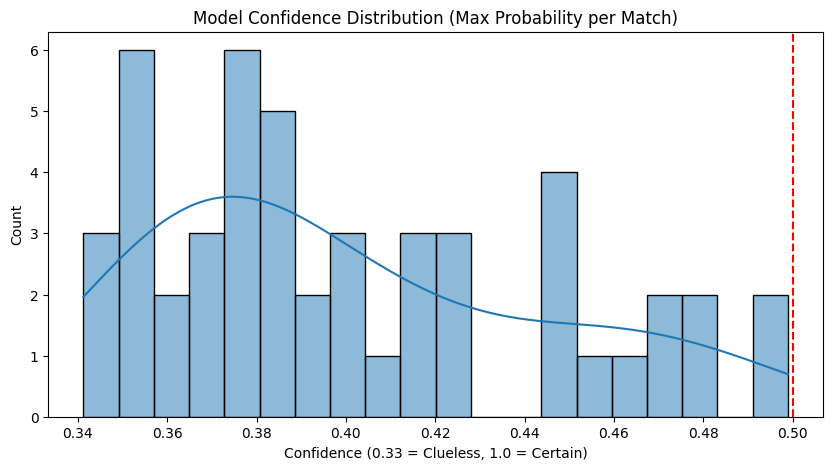

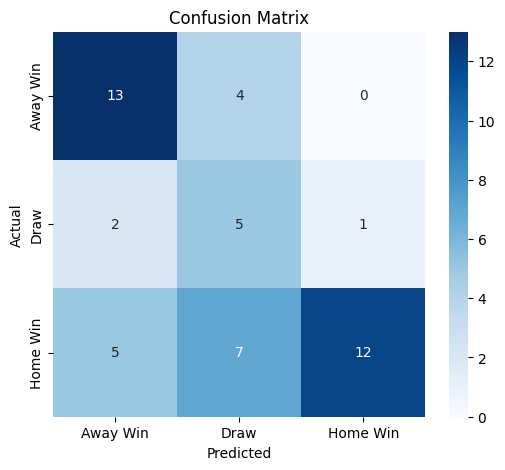


--- Match Predictions with Implied Odds ---
                Home                     Away  Pred  Prob_Home  \
440         Atalanta                 Cagliari     2   0.478798   
441        Liverpool   Brighton & Hove Albion     2   0.341227   
442      Sporting CP              AVS Futebol     2   0.446555   
443          Arsenal  Wolverhampton Wanderers     2   0.496029   
444             Metz      Paris Saint-Germain     0   0.267508   
445          Chelsea                  Everton     2   0.412879   
446  Atlético Madrid                 Valencia     1   0.320846   
447         Mallorca                    Elche     1   0.278701   
448   Crystal Palace          Manchester City     0   0.334533   
449       Sunderland         Newcastle United     1   0.282694   

     Model_Odds_Home  Actual  
440             2.09       2  
441             2.93       2  
442             2.24       2  
443             2.02       2  
444             3.74       0  
445             2.42       2  
446        

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# 1. VISUALIZE PROBABILITIES
# Let's see how confident the model usually is
plt.figure(figsize=(10, 5))
sns.histplot(np.max(probs, axis=1), bins=20, kde=True)
plt.axvline(x=0.5, color='r', linestyle='--')
plt.title('Model Confidence Distribution (Max Probability per Match)')
plt.xlabel('Confidence (0.33 = Clueless, 1.0 = Certain)')
plt.show()

# 2. CONFUSION MATRIX
# Did we predict Draws? (Class 1)
cm = confusion_matrix(y_test, preds)
classes = ['Away Win', 'Draw', 'Home Win']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# 3. IMPLIED ODDS (Value Betting)
# Convert Model Probability to Odds (1 / Prob)
# If Model Odds < Bookmaker Odds, it's a Value Bet.
results_df = pd.DataFrame({
    'Home': df.iloc[split_idx:]['home_team_name'],
    'Away': df.iloc[split_idx:]['away_team_name'],
    'Actual': y_test.values,
    'Pred': preds,
    'Prob_Home': probs[:, 2],
    'Prob_Draw': probs[:, 1],
    'Prob_Away': probs[:, 0]
})

# Calculate "Fair Odds" according to your model
results_df['Model_Odds_Home'] = round(1 / results_df['Prob_Home'], 2)
results_df['Model_Odds_Away'] = round(1 / results_df['Prob_Away'], 2)

print("\n--- Match Predictions with Implied Odds ---")
print(results_df[['Home', 'Away', 'Pred', 'Prob_Home', 'Model_Odds_Home', 'Actual']].head(10))

In [52]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Optional: Show what the model actually learned (Feature Importance)
importance = pd.DataFrame({
    'Feature': X.columns,
    'Score': best_model.feature_importances_
}).sort_values(by='Score', ascending=False)

print("Top 5 Key Predictors:")
print(importance.head(5))

# Get probabilities
probs = best_model.predict_proba(X_test)
results = pd.DataFrame({
    'Actual': y_test,
    'Pred': preds,
    'Conf': np.max(probs, axis=1) # Max probability (Confidence)
})

print(f"{'Threshold':<10} | {'Matches':<8} | {'Accuracy':<10} | {'Status'}")
print("-" * 50)

# Loop through thresholds from 40% to 60%
for threshold in [0.40, 0.45, 0.50, 0.55, 0.60]:
    # Filter bets with confidence > threshold
    subset = results[results['Conf'] > threshold]
    
    if len(subset) > 0:
        acc = accuracy_score(subset['Actual'], subset['Pred'])
        
        # Determine if this is a good strategy
        status = "POOR"
        if acc > 0.50: status = "OK"
        if acc > 0.55: status = "GOOD"
        if acc > 0.60: status = "EXCELLENT"
        
        print(f"{threshold:.2f}       | {len(subset):<8} | {acc:.2%}     | {status}")
    else:
        print(f"{threshold:.2f}       | 0        | N/A        | -")

Top 5 Key Predictors:
              Feature     Score
5  Specific_Form_Diff  0.215567
3       Home_HomeForm  0.140673
9       Away_Gen_Poss  0.121955
8       Home_Gen_Poss  0.120526
6         Home_Gen_XG  0.079521
Threshold  | Matches  | Accuracy   | Status
--------------------------------------------------
0.40       | 176      | 54.55%     | OK
0.45       | 140      | 57.14%     | GOOD
0.50       | 109      | 61.47%     | EXCELLENT
0.55       | 69       | 66.67%     | EXCELLENT
0.60       | 43       | 69.77%     | EXCELLENT


## Loading and Using model

In [ ]:
import pandas as pd
import numpy as np
import joblib
from scipy.optimize import minimize
import warnings

warnings.filterwarnings('ignore')

# ==========================================
# 1. LOAD THE ELO MODEL
# ==========================================
print("Loading ELO model...")
try:
    data = joblib.load('football_elo_model.pkl')
    best_model = data['model']
    team_stats = data['stats']
    le = data['encoder']
    print("ELO Model Loaded Successfully!")
except FileNotFoundError:
    print("Error: 'football_elo_model.pkl' not found.")
    exit()

# ==========================================
# 2. FEATURE GENERATION (ELO LOGIC)
# ==========================================
def get_match_features_elo(home_name, away_name, team_stats):
    if home_name not in team_stats or away_name not in team_stats:
        return None, f"One or both teams ({home_name}, {away_name}) not found."

    h = team_stats[home_name]
    a = team_stats[away_name]

    def get_avg(hist, window=5):
        if not hist: return 0
        return sum(hist[-window:]) / min(len(hist), window)

    # Extract Data (using .get() for safety)
    features = {
        'Home_Elo': h.get('elo', 1500),
        'Away_Elo': a.get('elo', 1500),
        'Elo_Diff': h.get('elo', 1500) - a.get('elo', 1500),
        
        'Home_HomeForm': get_avg(h.get('pts_home', [])),
        'Away_AwayForm': get_avg(a.get('pts_away', [])),
        'Specific_Form_Diff': get_avg(h.get('pts_home', [])) - get_avg(a.get('pts_away', [])),
        
        'Home_Gen_XG': get_avg(h.get('xg_all', [])),
        'Away_Gen_XG': get_avg(a.get('xg_all', [])),
        'Home_Gen_Poss': get_avg(h.get('poss_all', [])),
        'Away_Gen_Poss': get_avg(a.get('poss_all', []))
    }
    
    # EXACT column order from training
    cols = [
        'Home_Elo', 'Away_Elo', 'Elo_Diff',
        'Home_HomeForm', 'Away_AwayForm', 'Specific_Form_Diff',
        'Home_Gen_XG', 'Away_Gen_XG',
        'Home_Gen_Poss', 'Away_Gen_Poss'
    ]
    
    return pd.DataFrame([features], columns=cols), None

# ==========================================
# 3. OPTIMIZER ENGINE
# ==========================================
def optimize_stakes(all_bets, bankroll, max_risk, kelly_fraction):
    profitable_bets = []
    
    for bet in all_bets:
        p = bet['Model_Prob']
        odds = bet['Bookie_Odds']
        if odds <= 1: continue
        
        b = odds - 1
        q = 1 - p
        ev = (p * b) - q
        
        # Filter: Positive Edge Only
        if ev > 0.005: 
            profitable_bets.append({
                'Match': bet['Match_ID'],
                'Pick': bet['Pick'],
                'Prob': p,
                'Odds': odds,
                'b': b,
                'EV': ev
            })

    if not profitable_bets:
        return pd.DataFrame(), "No profitable bets found."

    n = len(profitable_bets)
    
    def objective(stakes):
        growth = 0
        for i, bet in enumerate(profitable_bets):
            f = stakes[i]
            if 1 - f <= 0: return np.inf
            growth += bet['Prob'] * np.log(1 + f * bet['b']) + (1 - bet['Prob']) * np.log(1 - f)
        return -growth

    cons = [{'type': 'ineq', 'fun': lambda x: max_risk - np.sum(x)}]
    bounds = [(0, max_risk) for _ in range(n)]
    guess = np.array([max_risk / (n*2)] * n)
    
    result = minimize(objective, guess, method='SLSQP', bounds=bounds, constraints=cons)

    if not result.success: return pd.DataFrame(), "Optimization failed."

    output = []
    optimal_stakes = result.x * kelly_fraction 
    
    for i, bet in enumerate(profitable_bets):
        stake_pct = optimal_stakes[i]
        cash = bankroll * stake_pct
        
        if cash > 1.00:
            fair_odds = 1 / bet['Prob']
            output.append({
                'Match': bet['Match'],
                'Pick': bet['Pick'],
                'Prob': f"{bet['Prob']:.1%}",
                'Real_Odds': bet['Odds'],
                'Fair_Odds': f"{fair_odds:.2f}",
                'Edge': f"{bet['EV']:.1%}",
                'Stake_%': f"{stake_pct:.2%}",
                'Cash': f"${cash:.2f}"
            })
            
    return pd.DataFrame(output), None

# ==========================================
# 4. EXECUTION WITH REAL ODDS
# ==========================================

# SETTINGS
BANKROLL = 1000  # Set your real bankroll here
MAX_RISK = 0.25   # Max 25% of bankroll for this entire batch
KELLY = 0.25      # Quarter Kelly Safety

# DATA EXTRACTED FROM YOUR IMAGE
upcoming_fixtures_with_odds = [
    # Today / Tonight
    {'Home': 'Tottenham Hotspur', 'Away': 'Liverpool', 'Home_Odds': 3.54, 'Draw_Odds': 3.60, 'Away_Odds': 2.08},
    {'Home': 'Everton', 'Away': 'Arsenal', 'Home_Odds': 6.17, 'Draw_Odds': 3.94, 'Away_Odds': 1.59},
    {'Home': 'Leeds United', 'Away': 'Crystal Palace', 'Home_Odds': 2.72, 'Draw_Odds': 3.19, 'Away_Odds': 2.76},
    
    # Tomorrow / Dec 22
    {'Home': 'Aston Villa', 'Away': 'Manchester United', 'Home_Odds': 2.11, 'Draw_Odds': 3.67, 'Away_Odds': 3.35},
    {'Home': 'Fulham', 'Away': 'Nottingham Forest', 'Home_Odds': 2.47, 'Draw_Odds': 3.26, 'Away_Odds': 2.99},
    
    # Boxing Day / Late Dec
    {'Home': 'Manchester United', 'Away': 'Newcastle United', 'Home_Odds': 2.12, 'Draw_Odds': 3.78, 'Away_Odds': 3.19},
    {'Home': 'Nottingham Forest', 'Away': 'Manchester City', 'Home_Odds': 4.91, 'Draw_Odds': 4.17, 'Away_Odds': 1.65},
    {'Home': 'Arsenal', 'Away': 'Brighton & Hove Albion', 'Home_Odds': 1.45, 'Draw_Odds': 4.61, 'Away_Odds': 7.12},
    {'Home': 'Brentford', 'Away': 'Bournemouth', 'Home_Odds': 2.26, 'Draw_Odds': 3.62, 'Away_Odds': 3.03},
    {'Home': 'Burnley', 'Away': 'Everton', 'Home_Odds': 4.14, 'Draw_Odds': 3.41, 'Away_Odds': 1.95},
    {'Home': 'Liverpool', 'Away': 'Wolverhampton Wanderers', 'Home_Odds': 1.22, 'Draw_Odds': 6.77, 'Away_Odds': 12.06},
    {'Home': 'West Ham United', 'Away': 'Fulham', 'Home_Odds': 2.70, 'Draw_Odds': 3.39, 'Away_Odds': 2.61},
    {'Home': 'Chelsea', 'Away': 'Aston Villa', 'Home_Odds': 1.84, 'Draw_Odds': 3.80, 'Away_Odds': 4.05},
    {'Home': 'Sunderland', 'Away': 'Leeds United', 'Home_Odds': 2.56, 'Draw_Odds': 3.33, 'Away_Odds': 2.77},
    {'Home': 'Crystal Palace', 'Away': 'Tottenham Hotspur', 'Home_Odds': 2.15, 'Draw_Odds': 3.42, 'Away_Odds': 3.36},
    {'Home': 'Manchester United', 'Away': 'Wolverhampton Wanderers', 'Home_Odds': 1.29, 'Draw_Odds': 5.90, 'Away_Odds': 9.80}
]

print("\nScanning market for value using ELO Model...")
all_bets = []

for f in upcoming_fixtures_with_odds:
    home, away = f['Home'], f['Away']
    match_id = f"{home} vs {away}"
    
    # Get Features
    feat, err = get_match_features_elo(home, away, team_stats)
    
    if err:
        # Try finding partial name matches if exact name fails
        print(f"Skipping {match_id}: {err}")
        continue
        
    probs = best_model.predict_proba(feat)[0] # [Away, Draw, Home]
    
    # Add potential bets
    all_bets.append({'Match_ID': match_id, 'Pick': 'Home', 'Model_Prob': probs[2], 'Bookie_Odds': f['Home_Odds']})
    all_bets.append({'Match_ID': match_id, 'Pick': 'Draw', 'Model_Prob': probs[1], 'Bookie_Odds': f['Draw_Odds']})
    all_bets.append({'Match_ID': match_id, 'Pick': 'Away', 'Model_Prob': probs[0], 'Bookie_Odds': f['Away_Odds']})

# Run Optimization
df_results, msg = optimize_stakes(all_bets, BANKROLL, MAX_RISK, KELLY)

print("\n" + "="*85)
print(f"OPTIMIZED ELO PORTFOLIO (Bankroll: ${BANKROLL})")
print("="*85)

if not df_results.empty:
    print(df_results.to_string(index=False))
    total = df_results['Cash'].str.replace('$','').astype(float).sum()
    print("-" * 85)
    print(f"TOTAL INVESTMENT: ${total:.2f} ({total/BANKROLL:.1%} of Bankroll)")
else:
    print(msg)

Loading ELO model...
ELO Model Loaded Successfully!

Scanning market for value using ELO Model...

OPTIMIZED ELO PORTFOLIO (Bankroll: $1000)
                                       Match Pick  Prob  Real_Odds Fair_Odds   Edge Stake_%   Cash
                          Everton vs Arsenal Home 28.0%       6.17      3.57  72.7%   0.53%  $5.26
        Nottingham Forest vs Manchester City Home 33.1%       4.91      3.02  62.7%   0.26%  $2.60
                          Burnley vs Everton Home 46.1%       4.14      2.17  90.9%   2.02% $20.16
        Liverpool vs Wolverhampton Wanderers Away 25.8%      12.06      3.88 210.6%   2.37% $23.72
Manchester United vs Wolverhampton Wanderers Away 21.7%       9.80      4.61 112.4%   1.06% $10.63
-------------------------------------------------------------------------------------
TOTAL INVESTMENT: $62.37 (6.2% of Bankroll)


In [48]:
import pandas as pd
import joblib

# Load the ELO Stats
# (Assuming 'team_stats' is loaded. If not, uncomment the lines below)
# data = joblib.load('football_elo_model.pkl')
# team_stats = data['stats']

def check_matchup_stats_elo(home, away):
    if home not in team_stats or away not in team_stats:
        print("One or both teams not found.")
        return

    h = team_stats[home]
    a = team_stats[away]
    
    # Helper to safe-get averages
    def get_avg(hist): return sum(hist[-5:]) / 5 if hist else 0
    def get_val(stats, key): return stats.get(key, 0)

    print(f"\n{'STATISTIC':<20} | {home.upper():<15} | {away.upper():<15} | {'EDGE'}")
    print("-" * 65)
    
    # 1. ELO RATING (The most important stat)
    h_elo = h.get('elo', 1500)
    a_elo = a.get('elo', 1500)
    print(f"{'ELO Rating':<20} | {str(round(h_elo, 0)):<15} | {str(round(a_elo, 0)):<15} | {'Home' if h_elo > a_elo else 'Away'}")

    # 2. FORM (Last 5 Games Points - using 'pts_all')
    h_form = get_avg(h.get('pts_all', []))
    a_form = get_avg(a.get('pts_all', []))
    print(f"{'Recent Form (Pts)':<20} | {h_form:<15.2f} | {a_form:<15.2f} | {'Home' if h_form > a_form else 'Away'}")

    # 3. ATTACK (Average xG - using 'xg_all')
    h_xg = get_avg(h.get('xg_all', []))
    a_xg = get_avg(a.get('xg_all', []))
    print(f"{'Attack (xG)':<20} | {h_xg:<15.2f} | {a_xg:<15.2f} | {'Home' if h_xg > a_xg else 'Away'}")

    # 4. POSSESSION (using 'poss_all')
    h_poss = get_avg(h.get('poss_all', []))
    a_poss = get_avg(a.get('poss_all', []))
    print(f"{'Possession':<20} | {h_poss:<15.1%} | {a_poss:<15.1%} | {'Home' if h_poss > a_poss else 'Away'}")

# Run it for the big anomaly
for upcoming_fixture in upcoming_fixtures_with_odds:
    check_matchup_stats_elo(upcoming_fixture["Home"],upcoming_fixture["Away"])


STATISTIC            | TOTTENHAM HOTSPUR | LIVERPOOL       | EDGE
-----------------------------------------------------------------
ELO Rating           | 1518.0          | 1547.0          | Away
Recent Form (Pts)    | 2.00            | 2.00            | Away
Attack (xG)          | 1.48            | 1.90            | Away
Possession           | 51.2%           | 53.0%           | Away

STATISTIC            | EVERTON         | ARSENAL         | EDGE
-----------------------------------------------------------------
ELO Rating           | 1538.0          | 1666.0          | Away
Recent Form (Pts)    | 2.60            | 1.60            | Home
Attack (xG)          | 1.32            | 1.74            | Away
Possession           | 42.0%           | 62.6%           | Away

STATISTIC            | LEEDS UNITED    | CRYSTAL PALACE  | EDGE
-----------------------------------------------------------------
ELO Rating           | 1464.0          | 1574.0          | Away
Recent Form (Pts)    | 1.40  

In [ ]:
import pandas as pd
import numpy as np
import joblib

# ==========================================
# 1. LOAD THE SAVED MODEL
# ==========================================
print("Loading model...")
data = joblib.load('football_model_optimized.pkl')

best_model = data['model']
team_stats = data['team_stats']
le = data['encoder']

print("Model Loaded Successfully!")

# ==========================================
# 2. PREDICTION FUNCTION
# ==========================================
def predict_weekend(mananger,matchups, model, team_stats, encoder):
    print(f"\n{'MATCHUP':<40} | {'HOME %':<7} | {'DRAW %':<7} | {'AWAY %':<7} | {'PREDICTION':<12} | {'ACTION'}")
    print("-" * 105)
    
    # Helper to calculate stats exactly like training
    def get_avg(hist, window=5):
        if not hist: return 0
        return sum(hist[-window:]) / min(len(hist), window)

    for home, away in matchups:
        # Check data exists
        if home not in team_stats or away not in team_stats:
            print(f"{home:<18} vs {away:<18} | ???     | ???     | ???     | N/A          | ❌ Unknown Team")
            continue
            
        h = team_stats[home]
        a = team_stats[away]
        
        # Build Features
        features = {
            'HomeTeam_ID': encoder.transform([home])[0],
            'AwayTeam_ID': encoder.transform([away])[0],
            'Home_Form_Pts': get_avg(h['pts']),
            'Away_Form_Pts': get_avg(a['pts']),
            'Form_Diff': get_avg(h['pts']) - get_avg(a['pts']),
            'Home_xG_Avg': get_avg(h['xg']),
            'Away_xG_Avg': get_avg(a['xg']),
            'xG_Diff': get_avg(h['xg']) - get_avg(a['xg']),
            'Home_xGA_Avg': get_avg(h['xga']),
            'Away_xGA_Avg': get_avg(a['xga']),
            'Def_Diff': get_avg(h['xga']) - get_avg(a['xga']),
            'Home_Poss_Avg': get_avg(h['poss']),
            'Away_Poss_Avg': get_avg(a['poss']),
            'Poss_Diff': get_avg(h['poss']) - get_avg(a['poss'])
        }
        
        row = pd.DataFrame([features])
        
        # Predict
        probs = model.predict_proba(row)[0]
        p_away, p_draw, p_home = probs[0], probs[1], probs[2]
        odds_away, odds_draw, odds_home = 1/probs[0], 1/probs[1], 1/probs[2]
        confidence = np.max(probs)
        pred_label = ['Away Win', 'Draw', 'Home Win'][np.argmax(probs)]
        
        # --- ACTION LOGIC (Based on your 72% Accuracy) ---
        action = "-"
        if confidence > 0.50: action = "Low Bet"
        if confidence > 0.55: action = "✅ BET"         # 65% Accuracy Zone
        if confidence > 0.60: action = "🔥 SNIPER BET"  # 72% Accuracy Zone
        
        if pred_label != 'Draw' and p_draw > 0.32: action += " (⚠️ Risky)"
        manager.calculate_bet(odds=odds_home, model_confidence=confidence, historic_accuracy=0.725)

        print(f"{home:<18} vs {away:<18} | {p_home:.1%} {odds_home:.1f}   | {p_draw:.1%} {odds_draw:.1f}   | {p_away:.1%} {odds_away:.1f}   | {pred_label:<12} | {action}")

# ==========================================
# 3. REAL FIXTURES (DEC 20-21, 2025)
# ==========================================
# Update this list with the matches you want to check today
weekend_games = [
    # Premier League
    ('Tottenham Hotspur', 'Liverpool'),
    ('Manchester City', 'West Ham United'),
    ('Aston Villa', 'Manchester United'),
    ('Everton', 'Arsenal'),
    ('Newcastle United', 'Chelsea'),
    
    # La Liga
    ('Real Madrid', 'Sevilla'),
    ('Villarreal', 'Barcelona'),
    ('Girona', 'Atlético Madrid'),
    
    # Serie A
    ('Juventus', 'Roma'),
    ('Napoli', 'Lazio')
]

# Run
predict_weekend(manager,weekend_games, best_model, team_stats, le)

Loading model...
Model Loaded Successfully!

MATCHUP                                  | HOME %  | DRAW %  | AWAY %  | PREDICTION   | ACTION
---------------------------------------------------------------------------------------------------------
Tottenham Hotspur  vs Liverpool          | 41.6% 2.4   | 25.4% 3.9   | 32.9% 3.0   | Home Win     | -
Manchester City    vs West Ham United    | 60.8% 1.6   | 22.9% 4.4   | 16.3% 6.1   | Home Win     | 🔥 SNIPER BET
Aston Villa        vs Manchester United  | 52.7% 1.9   | 22.0% 4.5   | 25.3% 3.9   | Home Win     | Low Bet
Everton            vs Arsenal            | 35.6% 2.8   | 20.8% 4.8   | 43.6% 2.3   | Away Win     | -
Newcastle United   vs Chelsea            | 37.8% 2.6   | 26.9% 3.7   | 35.3% 2.8   | Home Win     | -
Real Madrid        vs Sevilla            | 40.2% 2.5   | 26.6% 3.8   | 33.2% 3.0   | Home Win     | -
Villarreal         vs Barcelona          | 24.2% 4.1   | 20.7% 4.8   | 55.2% 1.8   | Away Win     | ✅ BET
Girona             

In [ ]:
def predict_weekend(matchups, model, team_stats, encoder):
